## Import libraries

In [1]:
!pip install EoN --upgrade
!pip install ffmpeg --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 17.3 MB/s 
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120820 sha256=f50189b073086652b1a93ef95c20b7bd5e69e53585ffe55dc2370492da00dcf1
  Stored in directory: /root/.cache/pip/wheels/a4/83/c4/108c801ed9d48177581562b9e60e44d009144d0d49b70e7bac
Successfully built EoN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=cc1f79597bd25fed6e24f5c686ec96df497c7ed42eec3ddd68c7331096896af7
  Stored in directory: /root/.cache/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg


In [2]:
# data and networks
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.ticker as mtick
import EoN
import ffmpeg
import scipy.interpolate as spip
import scipy.stats as sps

## Load network

In [7]:
# load network
!git clone https://github.com/mivazq/Network-Final-Project.git 
baseline_network = nx.read_graphml("/content/Network-Final-Project/Code & Data/simple_flight_network.graphml")

fatal: destination path 'Network-Final-Project' already exists and is not an empty directory.


In [8]:
# create dictionary of positions array ([longitude, latitude])
positions = {}
for node in baseline_network.nodes:
    long = nx.get_node_attributes(baseline_network, 'longitude')[node]
    lati = nx.get_node_attributes(baseline_network, 'latitude')[node]
    coor = np.array([long, lati])
    positions[node] = coor

## Compute centrality measures

In [9]:
unsorted_metrics = {}
sorted_metrics = {}

# compute measures, sort
unsorted_metrics['betweenness'] = nx.betweenness_centrality(baseline_network)
unsorted_metrics['closeness']   = nx.closeness_centrality(baseline_network)
unsorted_metrics['eigenvector'] = nx.eigenvector_centrality(baseline_network)
unsorted_metrics['indegree']    = nx.in_degree_centrality(baseline_network)
unsorted_metrics['outdegree']   = nx.out_degree_centrality(baseline_network)

# compute measures, sort
sorted_metrics['betweenness'] = dict(sorted(unsorted_metrics['betweenness'].items(), key=lambda item: item[1])) # get betweenness centrality, sorted ascending
sorted_metrics['closeness']   = dict(sorted(unsorted_metrics['closeness'].items(), key=lambda item: item[1])) # get closeness centrality, sorted ascending
sorted_metrics['eigenvector'] = dict(sorted(unsorted_metrics['eigenvector'].items(), key=lambda item: item[1])) # get eigenvector centrality, sorted ascending
sorted_metrics['indegree']    = dict(sorted(unsorted_metrics['indegree'].items(), key=lambda item: item[1])) # get in-degree centrality, sorted ascending
sorted_metrics['outdegree']   = dict(sorted(unsorted_metrics['outdegree'].items(), key=lambda item: item[1])) # get out-degree centrality, sorted ascending

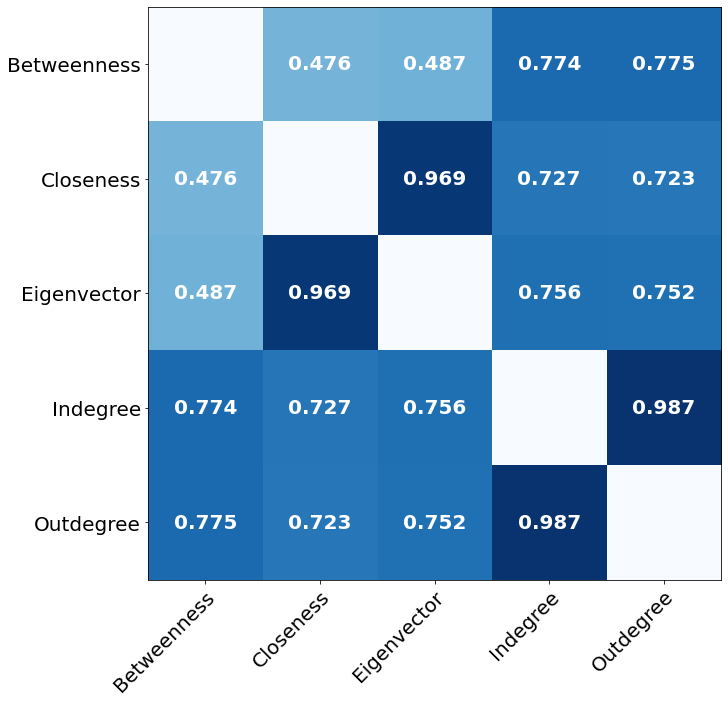

In [10]:
# Initiate empty correlation matrix
spearmanr_matrix = np.zeros((len(unsorted_metrics.keys()), len(unsorted_metrics.keys())))

# Fill matrix
for (i, metric1) in enumerate(list(unsorted_metrics.keys())):
    for (j, metric2) in enumerate(list(unsorted_metrics.keys())):

        # Calculate overlap, add to matrix
        a = np.array(list(unsorted_metrics[metric1].values()))
        b = np.array(list(unsorted_metrics[metric2].values()))
        spearmanr_matrix[i,j] = sps.spearmanr(a, b)[0]

# Replace diagonal with zeros to make it white
for i in range(len(unsorted_metrics.keys())):
    spearmanr_matrix[i,i] = 0

# Start figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
im = ax.imshow(spearmanr_matrix, cmap='Blues', norm=mpc.NoNorm())
#ax.set_title("Spearmann Rank Correlation Matrix")

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(unsorted_metrics.keys())))
ax.set_yticks(range(len(unsorted_metrics.keys())))
ax.set_xticklabels([el.capitalize() for el in list(unsorted_metrics.keys())], fontsize=20)
ax.set_yticklabels([el.capitalize() for el in list(unsorted_metrics.keys())], fontsize=20)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(unsorted_metrics.keys())):
    for j in range(len(unsorted_metrics.keys())):
        text = ax.text(j, i, round(spearmanr_matrix[i, j],3) if spearmanr_matrix[i, j]!=0 else '', ha="center", va="center", color="w", fontsize=20, fontweight='bold')

fig.savefig("/content/spearman_matrix.pdf", bbox_inches='tight', format='pdf', dpi=200)

## Create sub-networks where topX% nodes based on metrics are shut down (i.e. edges removal)


In [ ]:
# number of nodes
reduce_amount_max = 12
total_nodes = len(baseline_network.nodes)
print("Number of nodes in baseline network:",total_nodes)
for top in range(reduce_amount_max):
    print("\t",top+1,"% corresponds to",round(len(baseline_network.nodes)/100*(top+1)),"nodes")

Number of nodes in baseline network: 3284
	 1 % corresponds to 33 nodes
	 2 % corresponds to 66 nodes
	 3 % corresponds to 99 nodes
	 4 % corresponds to 131 nodes
	 5 % corresponds to 164 nodes
	 6 % corresponds to 197 nodes
	 7 % corresponds to 230 nodes
	 8 % corresponds to 263 nodes
	 9 % corresponds to 296 nodes
	 10 % corresponds to 328 nodes
	 11 % corresponds to 361 nodes
	 12 % corresponds to 394 nodes


In [ ]:
modified_networks = {}
shutted_nodes = {}

# Iterate over top1% to top10%
for top in range(reduce_amount_max):

    # Calculate topX% number of nodes to exclude
    topX = top+1
    nr_nodes_to_exclude = round(len(baseline_network.nodes)/100*(topX))
    
    # Iterate across different metrics
    for metric in sorted_metrics.keys():
        
        # Generate modified network without topX% of nodes based on 'metric'
        modified_networks[metric+'_no_top'+str(topX)] = baseline_network.copy()

        # Get list of nodes to remove
        shutted_nodes[metric+'_no_top'+str(topX)] = list(sorted_metrics[metric].keys())[-nr_nodes_to_exclude:]

        # Get list of edges to remove
        nodes_to_shut_down = shutted_nodes[metric+'_no_top'+str(topX)]
        edges_to_remove = []
        for node in nodes_to_shut_down:
            inedges  = list(modified_networks[metric+'_no_top'+str(topX)].in_edges(node))
            outedges = list(modified_networks[metric+'_no_top'+str(topX)].out_edges(node))
            edges_to_remove = edges_to_remove + inedges + outedges
        
        # Remove edges
        modified_networks[metric+'_no_top'+str(topX)].remove_edges_from(list(set(edges_to_remove)))     

# See results
print(modified_networks.keys())
print(modified_networks)

dict_keys(['betweenness_no_top1', 'closeness_no_top1', 'eigenvector_no_top1', 'indegree_no_top1', 'outdegree_no_top1', 'betweenness_no_top2', 'closeness_no_top2', 'eigenvector_no_top2', 'indegree_no_top2', 'outdegree_no_top2', 'betweenness_no_top3', 'closeness_no_top3', 'eigenvector_no_top3', 'indegree_no_top3', 'outdegree_no_top3', 'betweenness_no_top4', 'closeness_no_top4', 'eigenvector_no_top4', 'indegree_no_top4', 'outdegree_no_top4', 'betweenness_no_top5', 'closeness_no_top5', 'eigenvector_no_top5', 'indegree_no_top5', 'outdegree_no_top5', 'betweenness_no_top6', 'closeness_no_top6', 'eigenvector_no_top6', 'indegree_no_top6', 'outdegree_no_top6', 'betweenness_no_top7', 'closeness_no_top7', 'eigenvector_no_top7', 'indegree_no_top7', 'outdegree_no_top7', 'betweenness_no_top8', 'closeness_no_top8', 'eigenvector_no_top8', 'indegree_no_top8', 'outdegree_no_top8', 'betweenness_no_top9', 'closeness_no_top9', 'eigenvector_no_top9', 'indegree_no_top9', 'outdegree_no_top9', 'betweenness_no_t

In [ ]:
for netssss in modified_networks.values():
    print(netssss)

DiGraph with 3284 nodes and 28102 edges
DiGraph with 3284 nodes and 27471 edges
DiGraph with 3284 nodes and 28159 edges
DiGraph with 3284 nodes and 26595 edges
DiGraph with 3284 nodes and 26595 edges
DiGraph with 3284 nodes and 23587 edges
DiGraph with 3284 nodes and 21399 edges
DiGraph with 3284 nodes and 23019 edges
DiGraph with 3284 nodes and 20573 edges
DiGraph with 3284 nodes and 20573 edges
DiGraph with 3284 nodes and 20003 edges
DiGraph with 3284 nodes and 18100 edges
DiGraph with 3284 nodes and 19164 edges
DiGraph with 3284 nodes and 16387 edges
DiGraph with 3284 nodes and 16383 edges
DiGraph with 3284 nodes and 17318 edges
DiGraph with 3284 nodes and 15469 edges
DiGraph with 3284 nodes and 16392 edges
DiGraph with 3284 nodes and 13406 edges
DiGraph with 3284 nodes and 13436 edges
DiGraph with 3284 nodes and 15219 edges
DiGraph with 3284 nodes and 13541 edges
DiGraph with 3284 nodes and 14181 edges
DiGraph with 3284 nodes and 11222 edges
DiGraph with 3284 nodes and 11200 edges


## Test interpolation method

Unfortunately, our preferred module from EoN (fast_SIR) returns very inconsistent arrays of time steps and thus also number of infected nodes. Since we want to align all the simulation for the same metric, as well as the averages across the metrics, we need the *t*-steps to be uniform (or at least consistent). Thus, we using linear interpolation with quite small steps (one tenth of *t*) to recover uniform information on the number of infected nodes for all of our simulations.

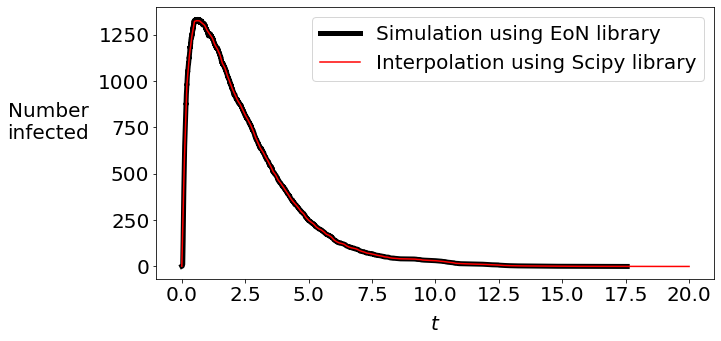

In [ ]:
### TESTING INTERPOLATION METHOD

# run baseline simulation
tmax = 20   # number of periods
tau = 0.005 # transmission rate
gamma = 0.5 # recovery rate
rho = 0.005 # share initial infected
t, S, I, R = EoN.fast_SIR(G=baseline_network, tau=tau, gamma=gamma, tmax = tmax, transmission_weight='weight')

# plot EoN produced simulation
plt.plot(t, I, color = 'black', alpha=1, label='Simulation using EoN library', linewidth=5)

# run interpolation (if values extend past the max value of the simulated t we just assign 0)
step = 0.1
t_step = np.arange(0, 20+step, step)
interp_func = spip.interpolate.interp1d(t, I, kind='linear', bounds_error=False, fill_value=0)
I_itplt = interp_func(t_step)
plt.plot(t_step, I_itplt, color = 'red', alpha=1, label='Interpolation using Scipy library')

# details of plot
plt.xlabel('$t$', fontsize=20, labelpad=10)
plt.ylabel('Number\ninfected', rotation=0, labelpad=50, fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.rcParams["figure.figsize"] = (10,5)

plt.savefig("/content/interpolation_test.pdf", bbox_inches='tight', format='pdf', dpi=200)

## Write function to embed simulations easily

In [ ]:
# define function to calculate standard error
def sterr(array):
    return sps.norm.ppf(0.975)*np.std(array, axis=0)/np.sqrt(array.shape[0])

In [ ]:
def compute_simulation(notopX_int, modified_networks_dict, iterations=100, tmax=20, tau=0.005, gamma=0.5, rho=0.005, sim_kwargs={'pos': positions}):

    # Interpolation parameters (Scipy)
    step = 0.1
    t_step = np.arange(0, tmax+step, step)
    
    # Populate number of infected dictionary with zero arrays
    Infected = {}
    Recovered = {}
    Peak = {}
    Peaktime = {}
    Tottime = {}
    metrics = list(set([x.split('_')[0] for x in list(modified_networks.keys())]))
    metrics.sort()
    different_nets = ['baseline']+metrics
    for net in different_nets:
        Infected[net] = np.zeros((iterations, len(t_step)))
        Recovered[net] = np.zeros((iterations, 1))
        Peak[net] = np.zeros((iterations, 1))
        Peaktime[net] = np.zeros((iterations, 1))
        Tottime[net] = np.zeros((iterations, 1))

    # Run 'iterations'
    for counter in range(iterations): 
        
        # run baseline simulation
        t, S, I, R = EoN.fast_SIR(G=baseline_network, 
                                  tau=tau, 
                                  gamma=gamma, 
                                  rho=rho, 
                                  tmax=tmax, 
                                  transmission_weight='weight',
                                  sim_kwargs=sim_kwargs)
        # interpolate to get uniform identical timestamps
        interp_func = spip.interp1d(t, I, kind='linear', bounds_error=False, fill_value=0)
        Infected['baseline'][counter] = interp_func(t_step)
        # store total recovered at end (i.e. total number of infected)
        Recovered['baseline'][counter] = R[-1]
        # store peak and peaktime
        Peak['baseline'][counter] = max(Infected['baseline'][counter])
        Peaktime['baseline'][counter] = t_step[np.argmax(Infected['baseline'][counter])]
        # store epidemic length (total time)
        Tottime['baseline'][counter] = max(t) # max(t-step) will always be 20, but t array stops when epidemic dies
        
        for metric in sorted_metrics.keys():
            # run all other simulations (modified networks)
            t, S, I, R = EoN.fast_SIR(G=modified_networks[metric+'_no_top'+str(notopX_int)], 
                                      tau=tau, 
                                      gamma=gamma, 
                                      rho=rho, 
                                      tmax = tmax, 
                                      transmission_weight='weight',
                                      sim_kwargs=sim_kwargs)
            # interpolate to get uniform identical timestamps
            interp_func = spip.interp1d(t, I, kind='linear', bounds_error=False, fill_value=0)
            Infected[metric][counter] = interp_func(t_step)
            # store total recovered at end (i.e. total number of infected)
            Recovered[metric][counter] = R[-1]
            # store peak and peaktime
            Peak[metric][counter] = max(Infected[metric][counter])
            Peaktime[metric][counter] = t_step[np.argmax(Infected[metric][counter])]
            # store epidemic length (total time)
            Tottime[metric][counter] = max(t) # max(t-step) will always be 20, but t array stops when epidemic dies
    
    # Take averages across all simulations
    for net in different_nets:
        Infected[net+'_avg'] = np.mean(Infected[net], axis=0)
        Infected[net+'_ste'] = sterr(Infected[net])
        Recovered[net+'_avg'] = np.mean(Recovered[net], axis=0)
        Recovered[net+'_ste'] = sterr(Recovered[net])
        Peak[net+'_avg'] = np.mean(Peak[net], axis=0)
        Peak[net+'_ste'] = sterr(Peak[net])
        Peaktime[net+'_avg'] = np.mean(Peaktime[net], axis=0)
        Peaktime[net+'_ste'] = sterr(Peaktime[net])
        Tottime[net+'_avg'] = np.mean(Tottime[net], axis=0)
        Tottime[net+'_ste'] = sterr(Tottime[net])

    return (t_step, Infected, Recovered, Peak, Peaktime, Tottime, different_nets)

## Run simulations, store key values

In [ ]:
Infected_topX = {}
Peak_share_topX = {}
Recovered_share_topX = {}
Peaktime_topX = {}
Tottime_topX = {}

for x in range(reduce_amount_max):
    
        # Run simulation
        t_step, Infected, Recovered, Peak, Peaktime, Tottime, all_metrics = compute_simulation(x+1,  modified_networks, iterations=100)
        
        for el in all_metrics:

            # Relativize measures of peak/total infected, store for every topX%
            Infected_topX[el+'_no_top'+str(x+1)+'_avg'] = np.array(Infected[el+'_avg']) # this is an array, not a single value
            Infected_topX[el+'_no_top'+str(x+1)+'_err'] = np.array(Infected[el+'_ste']) # this is an array, not a single value
            Peak_share_topX[el+'_no_top'+str(x+1)+'_avg'] = float(Peak[el+'_avg'])/total_nodes
            Peak_share_topX[el+'_no_top'+str(x+1)+'_err'] = float(Peak[el+'_ste'])/total_nodes
            Recovered_share_topX[el+'_no_top'+str(x+1)+'_avg'] = float(Recovered[el+'_avg'])/total_nodes
            Recovered_share_topX[el+'_no_top'+str(x+1)+'_err'] = float(Recovered[el+'_ste'])/total_nodes
            Peaktime_topX[el+'_no_top'+str(x+1)+'_avg'] = float(Peaktime[el+'_avg'])
            Peaktime_topX[el+'_no_top'+str(x+1)+'_err'] = float(Peaktime[el+'_ste'])
            Tottime_topX[el+'_no_top'+str(x+1)+'_avg'] = float(Tottime[el+'_avg'])
            Tottime_topX[el+'_no_top'+str(x+1)+'_err'] = float(Tottime[el+'_ste'])

## Epidemic courses for top1-top12%

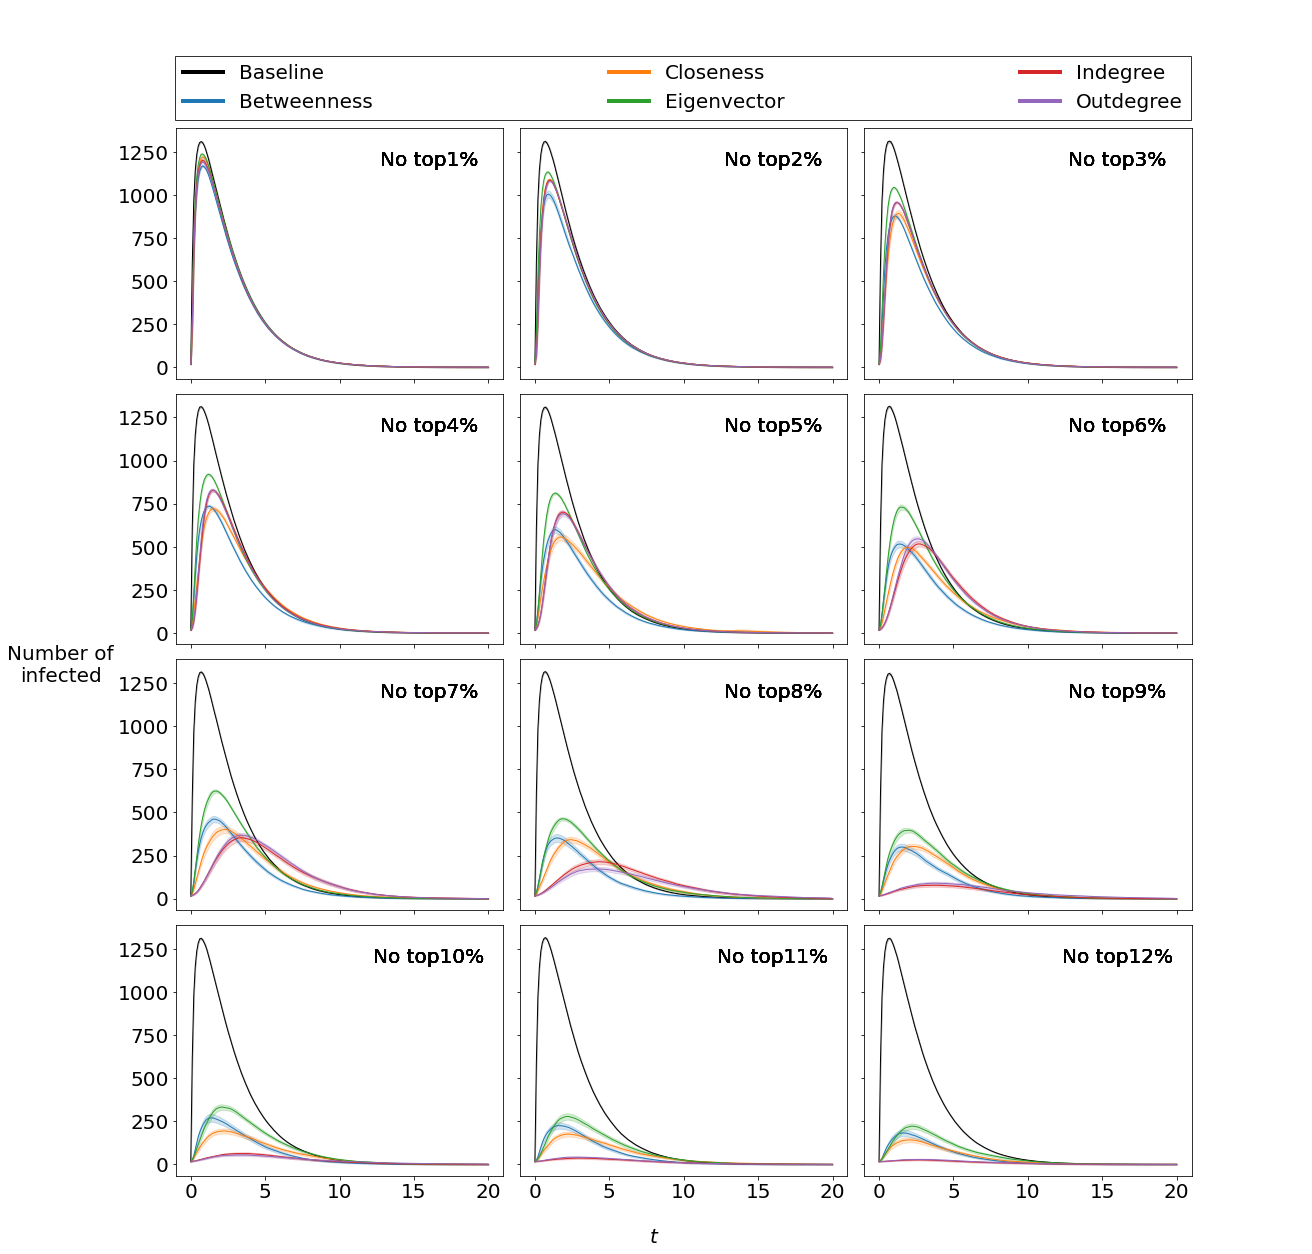

In [ ]:
# Plot average epidemic courses of topX
fig, axs = plt.subplots(4, 3, figsize=(15, 15), constrained_layout=True, sharex=True, sharey=True)

for (ax, x) in zip(axs.flat, range(len(axs.flat))):
  
    for (c, el) in enumerate(all_metrics):

        # Plot epidemic courses (Number of infeceted)
        if x==0:
            ax.plot(t_step, Infected_topX[el+'_no_top'+str(x+1)+'_avg'], label=el.capitalize(), linewidth=1, color='black' if el=='baseline' else 'C'+str(c-1))
        else:
            ax.plot(t_step, Infected_topX[el+'_no_top'+str(x+1)+'_avg'], linewidth=1, color='black' if el=='baseline' else 'C'+str(c-1))
        ci_upper = np.array(Infected_topX[el+'_no_top'+str(x+1)+'_avg']) + np.array(Infected_topX[el+'_no_top'+str(x+1)+'_err'])
        ci_lower = np.array(Infected_topX[el+'_no_top'+str(x+1)+'_avg']) - np.array(Infected_topX[el+'_no_top'+str(x+1)+'_err'])
        ax.fill_between(t_step, ci_lower, ci_upper, alpha=.2, color='black' if el=='baseline' else 'C'+str(c-1))
        ax.tick_params(labelsize=20)
        strlabel = 'No top'+str(x+1)+'%'
        ax.text(16, 1200, strlabel, ha='center', va='center', fontsize=20)

fig.text(0.5, -0.03, '$t$', ha='center', va='center', fontsize=20)
fig.text(-0.05, 0.5, 'Number of\ninfected', ha='center', va='center', rotation=0, fontsize=20)
legend = fig.legend(bbox_to_anchor=(0.162, 1.05, 0.941, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3, fontsize=20, edgecolor='black', fancybox=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(4)
fig.show()
fig.savefig("/content/epidemic_course.pdf", bbox_inches='tight', format='pdf', dpi=200)

## Effect on outcomes of interest

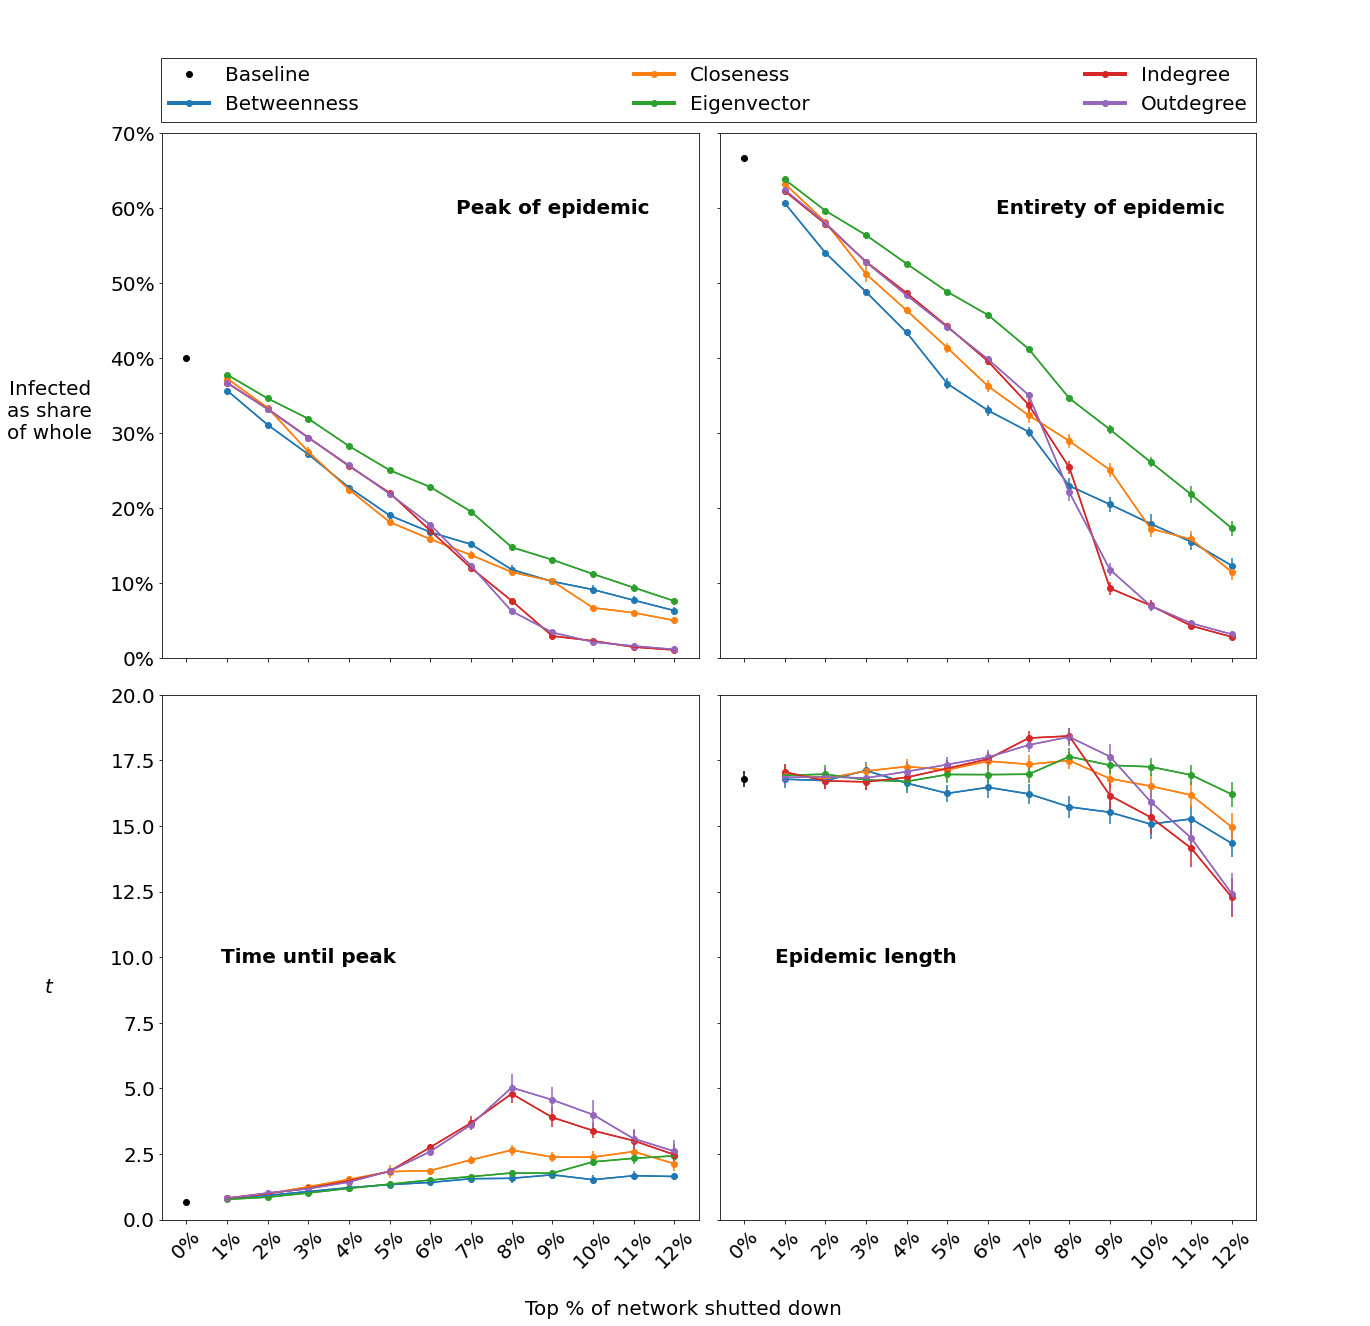

In [ ]:
# Plot average epidemic courses of topX
fig, axs = plt.subplots(2, 2, figsize=(16, 16), constrained_layout=True, sharex=True, sharey='row')

############## EFFECT ON INFECTED PEAK
# Add baseline
tot_avg = 0; tot_err = 0
for i in range(reduce_amount_max):
    tot_avg += Peak_share_topX['baseline_no_top'+str(i+1)+'_avg']
    tot_err += Peak_share_topX['baseline_no_top'+str(i+1)+'_err']
mean_avg = tot_avg/len(range(reduce_amount_max))
mean_err = tot_err/len(range(reduce_amount_max))
axs[0,0].plot(0, mean_avg, marker='o', linestyle='none', color='black', label='Baseline')
axs[0,0].errorbar(0, mean_avg, yerr=mean_err, color='black')

# Plot for different metrics
for (c, el) in enumerate(sorted_metrics.keys()):
    x = [i+1 for i in range(reduce_amount_max)]
    y = [Peak_share_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    yerr = [Peak_share_topX[el+'_no_top'+str(i+1)+'_err'] for i in range(reduce_amount_max)]
    axs[0,0].plot(x, y, marker='o', label=el.capitalize(), color='C'+str(c))
    axs[0,0].errorbar(x, y, yerr=yerr, color='C'+str(c))
axs[0,0].set_xticks(range(reduce_amount_max+1))
axs[0,0].set_xticklabels([str(i)+'%' for i in range(reduce_amount_max+1)], rotation=45)
axs[0,0].set_ylim(bottom=0, top=0.7)
axs[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0,0].tick_params(labelsize=20)
axs[0,0].text(9, 0.6, 'Peak of epidemic', ha='center', va='center', rotation=0, fontsize=20, fontweight='bold')




############## EFFECT ON TOTAL INFECTED
# Add baseline
tot_avg = 0; tot_err = 0
for i in range(reduce_amount_max):
    tot_avg += Recovered_share_topX['baseline_no_top'+str(i+1)+'_avg']
    tot_err += Recovered_share_topX['baseline_no_top'+str(i+1)+'_err']
mean_avg = tot_avg/len(range(reduce_amount_max))
mean_err = tot_err/len(range(reduce_amount_max))
axs[0,1].plot(0, mean_avg, color='black', marker='o', linestyle='none')
axs[0,1].errorbar(0, mean_avg, yerr=mean_err, color='black')

# Plot for different metrics
for (c, el) in enumerate(sorted_metrics.keys()):
    x = [i+1 for i in range(reduce_amount_max)]
    y = [Recovered_share_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    y = [Recovered_share_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    yerr = [Recovered_share_topX[el+'_no_top'+str(i+1)+'_err'] for i in range(reduce_amount_max)]
    axs[0,1].plot(x, y, marker='o', color='C'+str(c))
    axs[0,1].errorbar(x, y, yerr=yerr, color='C'+str(c))
axs[0,1].set_xticks(range(reduce_amount_max+1))
axs[0,1].set_xticklabels([str(i)+'%' for i in range(reduce_amount_max+1)], rotation=45)
axs[0,1].set_ylim(bottom=0)
axs[0,1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0,1].tick_params(labelsize=20)
axs[0,1].text(9, 0.6, 'Entirety of epidemic', ha='center', va='center', rotation=0, fontsize=20, fontweight='bold')




############## EFFECT ON TIME TO PEAK

# Add baseline
tot_avg = 0; tot_err = 0
for i in range(reduce_amount_max):
    tot_avg += Peaktime_topX['baseline_no_top'+str(i+1)+'_avg']
    tot_err += Peaktime_topX['baseline_no_top'+str(i+1)+'_err']
mean_avg = tot_avg/len(range(reduce_amount_max))
mean_err = tot_err/len(range(reduce_amount_max))
axs[1,0].plot(0, mean_avg, color='black', marker='o', linestyle='none')
axs[1,0].errorbar(0, mean_avg, yerr=mean_err, color='black')

# Plot for different metrics
for (c, el) in enumerate(sorted_metrics.keys()):
    x = [i+1 for i in range(reduce_amount_max)]
    y = [Peaktime_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    y = [Peaktime_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    yerr = [Peaktime_topX[el+'_no_top'+str(i+1)+'_err'] for i in range(reduce_amount_max)]
    axs[1,0].plot(x, y, marker='o', color='C'+str(c))
    axs[1,0].errorbar(x, y, yerr=yerr, color='C'+str(c))
axs[1,0].set_xticks(range(reduce_amount_max+1))
axs[1,0].set_xticklabels([str(i)+'%' for i in range(reduce_amount_max+1)], rotation=45)
axs[1,0].set_ylim(bottom=0, top=20)
axs[1,0].tick_params(labelsize=20)
axs[1,0].text(3, 10, 'Time until peak', ha='center', va='center', rotation=0, fontsize=20, fontweight='bold')



############## EFFECT ON EPIDEMIC LENGTH

# Add baseline
tot_avg = 0; tot_err = 0
for i in range(reduce_amount_max):
    tot_avg += Tottime_topX['baseline_no_top'+str(i+1)+'_avg']
    tot_err += Tottime_topX['baseline_no_top'+str(i+1)+'_err']
mean_avg = tot_avg/len(range(reduce_amount_max))
mean_err = tot_err/len(range(reduce_amount_max))
axs[1,1].plot(0, mean_avg, color='black', marker='o', linestyle='none')
axs[1,1].errorbar(0, mean_avg, yerr=mean_err, color='black')

# Plot for different metrics
for (c, el) in enumerate(sorted_metrics.keys()):
    x = [i+1 for i in range(reduce_amount_max)]
    y = [Tottime_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    y = [Tottime_topX[el+'_no_top'+str(i+1)+'_avg'] for i in range(reduce_amount_max)]
    yerr = [Tottime_topX[el+'_no_top'+str(i+1)+'_err'] for i in range(reduce_amount_max)]
    axs[1,1].plot(x, y, marker='o', color='C'+str(c))
    axs[1,1].errorbar(x, y, yerr=yerr, color='C'+str(c))
axs[1,1].set_xticks(range(reduce_amount_max+1))
axs[1,1].set_xticklabels([str(i)+'%' for i in range(reduce_amount_max+1)], rotation=45)
axs[1,1].set_ylim(bottom=0, top=20)
axs[1,1].tick_params(labelsize=20)
axs[1,1].text(3, 10, 'Epidemic length', ha='center', va='center', rotation=0, fontsize=20, fontweight='bold')



fig.text(0.5, -0.03, 'Top % of network shutted down', ha='center', va='center', fontsize=20)
fig.text(-0.05, 0.75, 'Infected\nas share\nof whole', ha='center', va='center', rotation=0, fontsize=20)
fig.text(-0.05, 0.25, '$t$', ha='center', va='center', rotation=0, fontsize=20)
legend = fig.legend(bbox_to_anchor=(0.14, 1.045, 0.95, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3, fontsize=20, edgecolor='black', fancybox=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(4)
fig.show()
fig.savefig("/content/interest_outcomes.pdf", bbox_inches='tight', format='pdf', dpi=200)

## Matrix of shared

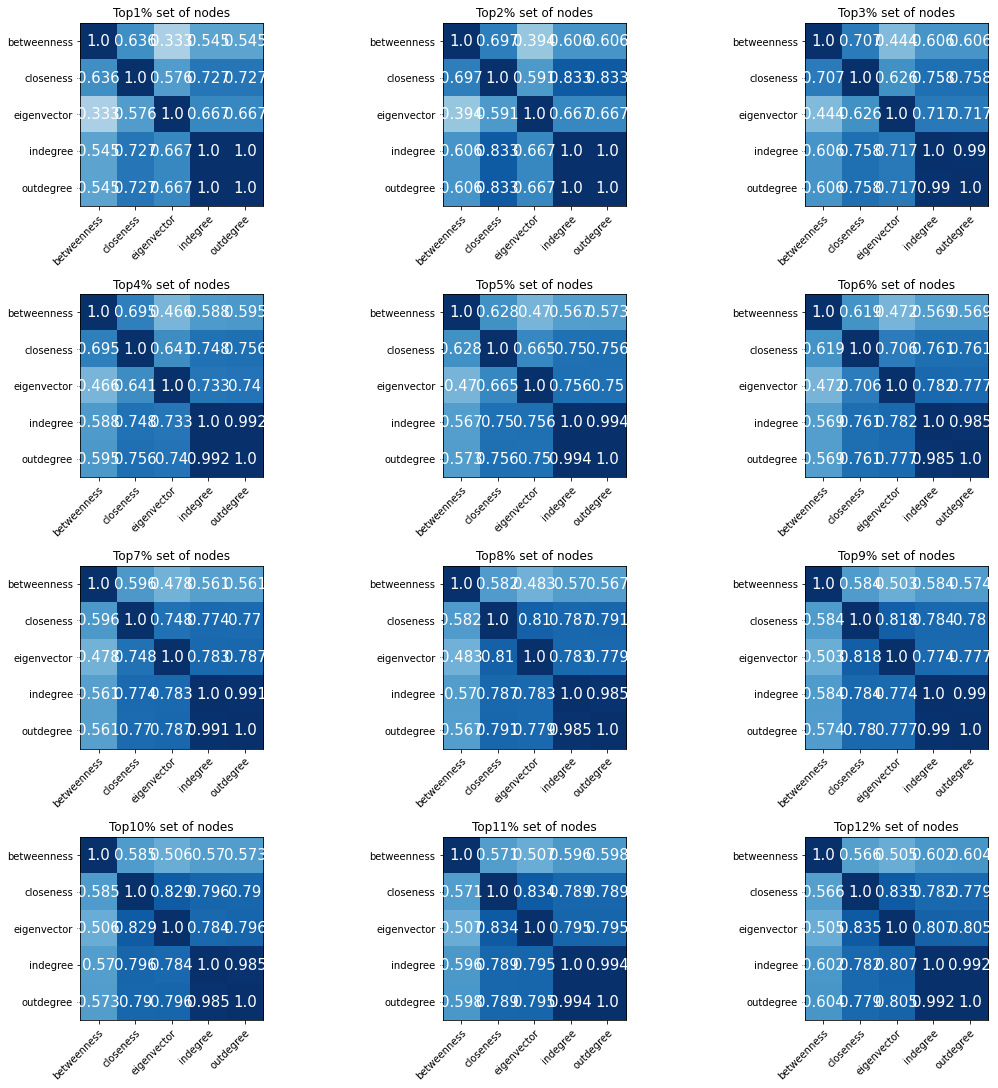

In [ ]:
# Plot average epidemic courses of topX
fig, axs = plt.subplots(4, 3, figsize=(15, 15), constrained_layout=True)

for (ax, n) in zip(axs.flat, range(len(axs.flat))):

    # Initiate empty correlation matrix
    corr_matrix = np.zeros((len(sorted_metrics.keys()), len(sorted_metrics.keys())))

    # Fill matrix
    for (i, metric1) in enumerate(list(sorted_metrics.keys())):
        for (j, metric2) in enumerate(list(sorted_metrics.keys())):

            # Get set of nodes
            m1 = set(shutted_nodes[metric1+'_no_top'+str(n+1)])
            m2 = set(shutted_nodes[metric2+'_no_top'+str(n+1)])

            # Calculate overlap, add to matrix
            corr = len(m1.intersection(m2))/len(m1)
            corr_matrix[i,j] = corr

    # Start figure
    im = ax.imshow(corr_matrix, cmap='Blues', norm=mpc.NoNorm())
    ax.set_title("Top"+str(n+1)+"% set of nodes")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(sorted_metrics.keys())))
    ax.set_yticks(range(len(sorted_metrics.keys())))
    ax.set_xticklabels(list(sorted_metrics.keys()))
    ax.set_yticklabels(list(sorted_metrics.keys()))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(sorted_metrics.keys())):
        for j in range(len(sorted_metrics.keys())):
            text = ax.text(j, i, round(corr_matrix[i, j],3), ha="center", va="center", color="w", fontsize=15)


2562


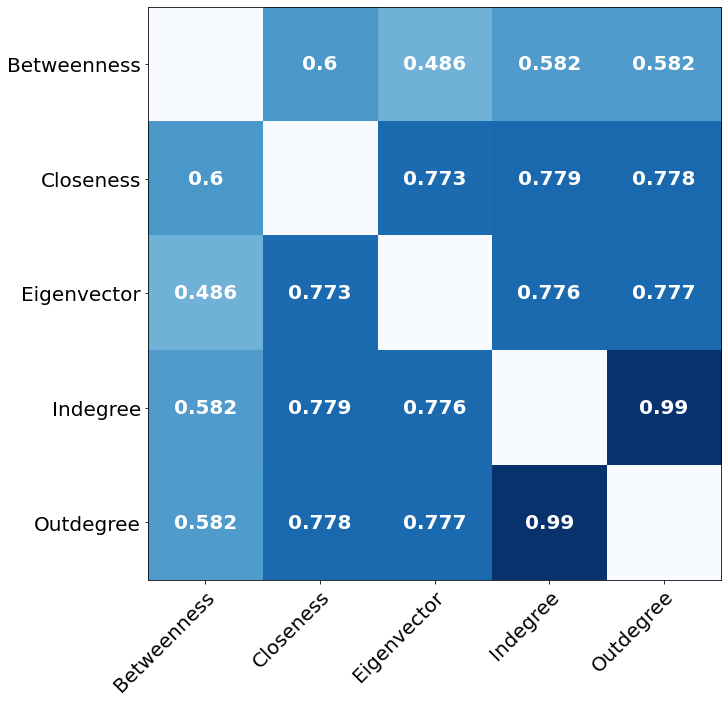

In [ ]:
# Same as above, but averages across the 12 pictures

# Initiate empty correlation matrix
corr_matrix = np.zeros((len(sorted_metrics.keys()), len(sorted_metrics.keys())))
sizes = 0

# Iterate over 12 matrices and add
for n in range(reduce_amount_max):

    # Fill matrix
    for (i, metric1) in enumerate(list(sorted_metrics.keys())):
        for (j, metric2) in enumerate(list(sorted_metrics.keys())):

            # Get set of nodes
            m1 = set(shutted_nodes[metric1+'_no_top'+str(n+1)])
            m2 = set(shutted_nodes[metric2+'_no_top'+str(n+1)])

            # Calculate overlap, add to matrix
            corr = len(m1.intersection(m2))
            corr_matrix[i,j] += corr

    # Append size of node removal operation
    sizes += len(m1)

print(sizes)

# Divide by 12 times the total number of removed nodes to get average
corr_matrix = corr_matrix/sizes
corr_matrix

# Replace diagonal with zeros to make it white
for i in range(len(unsorted_metrics.keys())):
    corr_matrix[i,i] = 0

# Start figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
im = ax.imshow(corr_matrix, cmap='Blues', norm=mpc.NoNorm())

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(unsorted_metrics.keys())))
ax.set_yticks(range(len(unsorted_metrics.keys())))
ax.set_xticklabels([el.capitalize() for el in list(unsorted_metrics.keys())], fontsize=20)
ax.set_yticklabels([el.capitalize() for el in list(unsorted_metrics.keys())], fontsize=20)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(unsorted_metrics.keys())):
    for j in range(len(unsorted_metrics.keys())):
        text = ax.text(j, i, round(corr_matrix[i, j],3) if corr_matrix[i, j]!=0 else '', ha="center", va="center", color="w", fontsize=20, fontweight='bold')

fig.savefig("/content/node_remove_overlap_matrix.pdf", bbox_inches='tight', format='pdf', dpi=200)